<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Import Libraries and Setup</font>
</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import random

import time
import os
import PIL.Image as Image
from IPython.display import display
from sklearn.metrics import precision_recall_fscore_support

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usefashrfi/iran-used-cars-dataset")

print("Path to dataset files:", path)

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Data Loading and Preparation</font>
</p>

<p style="text-align:left;">
    <font face="Georgia" size=5 color="red">Integrating two dataset</font>
</p>

- dataset 1: Standford car dataset
- dataset 2: Iran cars

In [3]:
# Define the paths to the datasets
dataset1_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data'
dataset2_dir = '/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split'

train_dir1 = os.path.join(dataset1_dir, 'train')
test_dir1 = os.path.join(dataset1_dir, 'test')

train_dir2 = os.path.join(dataset2_dir, 'train')
test_dir2 = os.path.join(dataset2_dir, 'test')

# Define transforms for training and testing
train_transforms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets separately using ImageFolder
train_dataset1_original = torchvision.datasets.ImageFolder(root=train_dir1, transform=train_transforms)
test_dataset1_original = torchvision.datasets.ImageFolder(root=test_dir1, transform=test_transforms)

train_dataset2_original = torchvision.datasets.ImageFolder(root=train_dir2, transform=train_transforms)
test_dataset2_original = torchvision.datasets.ImageFolder(root=test_dir2, transform=test_transforms)

# Create unified class mapping
all_classes = sorted(list(set(train_dataset1_original.classes + train_dataset2_original.classes)))
unified_class_to_idx = {cls_name: idx for idx, cls_name in enumerate(all_classes)}

print(f"Total number of unique classes across both datasets: {len(all_classes)}")

Total number of unique classes across both datasets: 209


In [5]:
# Define custom dataset class for remapping labels
class CustomImageDataset(Dataset):
    def __init__(self, image_folder_dataset, unified_mapping):
        self.dataset = image_folder_dataset
        self.unified_mapping = unified_mapping
        self.classes = list(unified_mapping.keys())
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, old_label = self.dataset[idx]
        class_name = self.dataset.classes[old_label]
        new_label = self.unified_mapping[class_name]
        return image, new_label
    
    def get_original_class_name(self, idx):
        _, label = self.dataset[idx]
        return self.dataset.classes[label]

# Apply unified mapping to all datasets
train_dataset1 = CustomImageDataset(train_dataset1_original, unified_class_to_idx)
test_dataset1 = CustomImageDataset(test_dataset1_original, unified_class_to_idx)

train_dataset2 = CustomImageDataset(train_dataset2_original, unified_class_to_idx)
test_dataset2 = CustomImageDataset(test_dataset2_original, unified_class_to_idx)

# Concatenate datasets with consistent labeling
combined_train_dataset = ConcatDataset([train_dataset1, train_dataset2])
combined_test_dataset = ConcatDataset([test_dataset1, test_dataset2])

# Create DataLoaders
trainloader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Print statistics
print(f"Number of samples in combined train dataset: {len(combined_train_dataset)}")
print(f"Number of samples in combined test dataset: {len(combined_test_dataset)}")
print(f"Original dataset 1 classes: {len(train_dataset1_original.classes)}")
print(f"Original dataset 2 classes: {len(train_dataset2_original.classes)}")

Number of samples in combined train dataset: 14953
Number of samples in combined test dataset: 9515
Original dataset 1 classes: 196
Original dataset 2 classes: 13


<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Visualization Function</font>
</p>

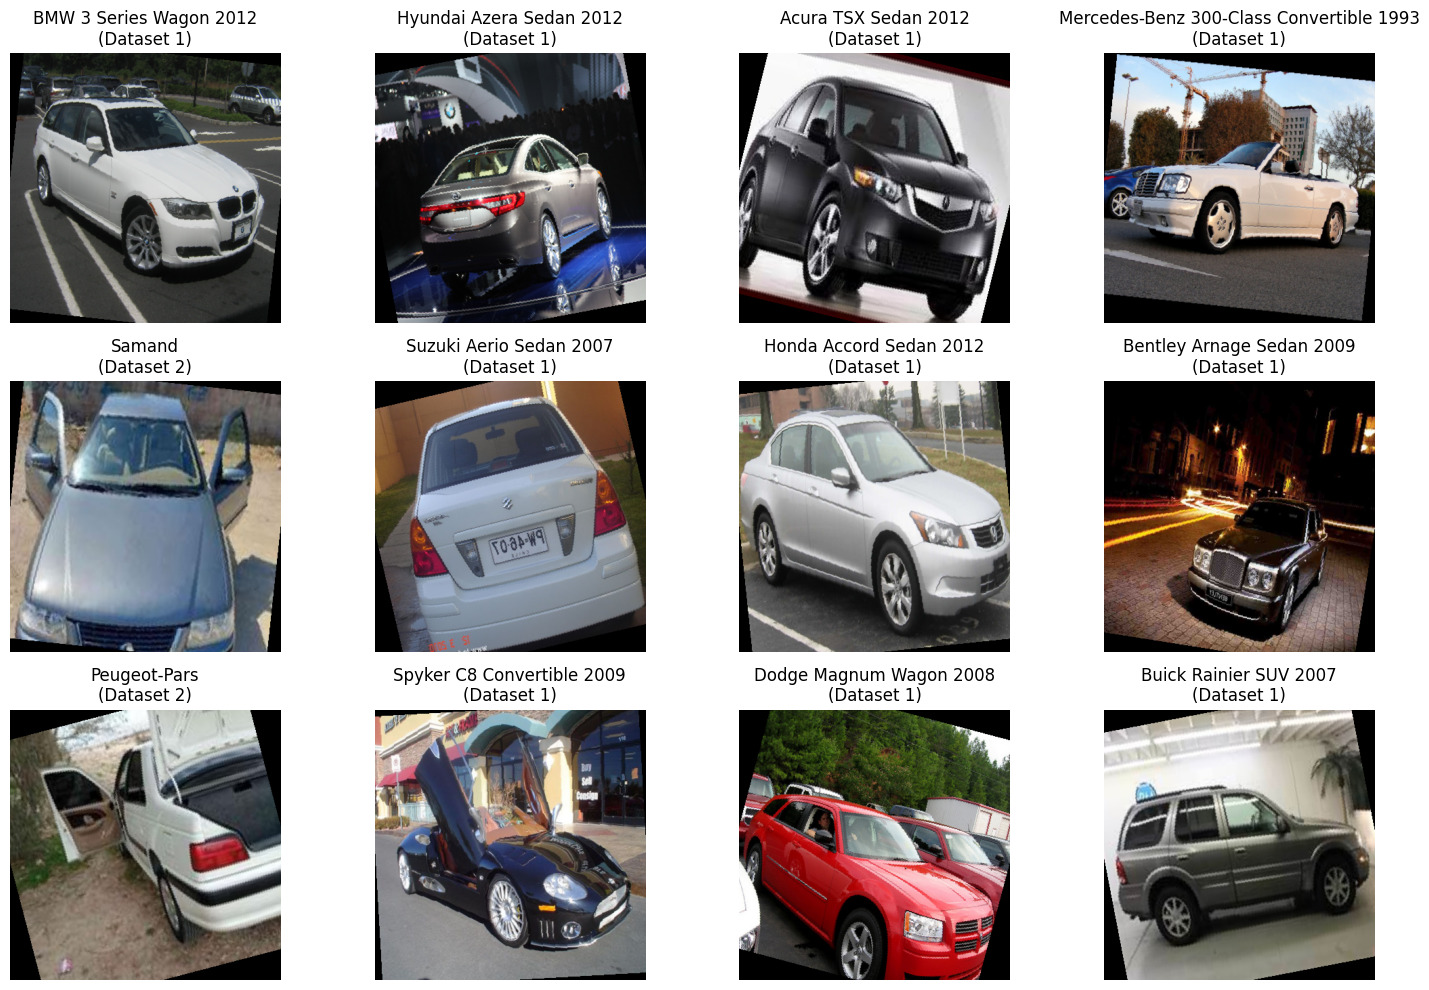

In [6]:
def show_sample_images():
    # Get random samples from combined dataset
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()
    
    combined_size = len(combined_train_dataset)
    for i, ax in enumerate(axes):
        random_idx = random.randint(0, combined_size - 1)
        image, label = combined_train_dataset[random_idx]
        
        # Determine which dataset and get class name
        if random_idx < len(train_dataset1):
            dataset_source = "Dataset 1"
            class_name = train_dataset1.get_original_class_name(random_idx)
        else:
            dataset_source = "Dataset 2"
            class_name = train_dataset2.get_original_class_name(random_idx - len(train_dataset1))
        
        # Convert tensor to image
        img = image.permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f"{class_name}\n({dataset_source})")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images()

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Training loop</font>
</p>

In [7]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1_scores = []
    
    # For best model saving
    best_acc = 0.0
    
    # For early stopping
    patience = 5
    counter = 0
    best_val_loss = float('inf')
    
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        print('-' * 20)
        print(f'Starting epoch {epoch+1}/{n_epochs}')
        since = time.time()
        running_loss = 0.0
        
        # Use running counters for efficiency
        running_correct = 0
        running_total = 0
        y_true = []
        y_pred = []
        
        # Add progress bar
        loop = tqdm(trainloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for i, data in enumerate(loop, 0):
            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            
            # Update running counters
            running_correct += (predicted == labels).sum().item()
            running_total += labels.size(0)
            
            # collect predictions and labels for metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
            # Update progress bar
            loop.set_postfix(loss=running_loss/(i+1), acc=100.0*running_correct/running_total)

        # Calculate metrics at the end of epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100.0 * running_correct / running_total
        
        # Calculate all metrics using sklearn
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0
        )
        
        print(f"Epoch {epoch+1}, duration: {epoch_duration:.0f}s, loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_metrics = eval_model(model)
        test_accuracies.append(test_metrics['accuracy'])
        test_precisions.append(test_metrics['precision'])
        test_recalls.append(test_metrics['recall'])
        test_f1_scores.append(test_metrics['f1'])
        
        # Save best model based on test accuracy
        if test_metrics['accuracy'] > best_acc:
            best_acc = test_metrics['accuracy']
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✅ New best model saved with accuracy: {best_acc:.4f}")
        
        # Early stopping based on validation loss
        if 'loss' in test_metrics:
            test_loss = test_metrics['loss']
        else:
            # If eval_model doesn't return loss, compute it
            test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
            test_loss /= len(testloader)
            
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"⚠️ Early stopping triggered at epoch {epoch+1}")
                break
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_metrics['accuracy'])
        
    print('✨ Finished Training')
    return model, losses, accuracies, test_accuracies, precisions, recalls, f1_scores, test_precisions, test_recalls, test_f1_scores

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Evaluating function</font>
</p>

In [8]:
def eval_model(model, criterion=None):
    """Evaluate model on test data and return all metrics"""
    
    since = time.time()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    y_true = []
    y_pred = []
    
    # Create progress bar
    loop = tqdm(testloader, desc="Evaluating")
    
    with torch.no_grad():
        for i, data in enumerate(loop):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            # Calculate loss if criterion is provided
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            
            # Update counters for accuracy
            running_correct += (predicted == labels).sum().item()
            running_total += labels.size(0)
            
            # Collect labels and predictions for detailed metrics
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
            # Update progress bar
            loop.set_postfix(acc=100.0*running_correct/running_total)
    
    # Calculate metrics
    accuracy = 100.0 * running_correct / running_total
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    
    # Calculate average loss if criterion was provided
    avg_loss = running_loss / len(testloader) if criterion is not None else None
    
    eval_duration = time.time() - since
    print(f'Evaluation complete in {eval_duration:.0f}s')
    print(f'Test Accuracy: {accuracy:.4f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Add loss to metrics if calculated
    if avg_loss is not None:
        metrics['loss'] = avg_loss
        print(f'Test Loss: {avg_loss:.4f}')
        
    return metrics

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Feature extractor</font>
</p>

- Resnet18

In [10]:
model = models.resnet18(pretrained=True)

#changeing classification head to match our dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(all_classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [11]:
# Print model summary
print("Model Architecture:")
summary(model, (3, 400, 400), device=device.type)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           9,408
       BatchNorm2d-2         [-1, 64, 200, 200]             128
              ReLU-3         [-1, 64, 200, 200]               0
         MaxPool2d-4         [-1, 64, 100, 100]               0
            Conv2d-5         [-1, 64, 100, 100]          36,864
       BatchNorm2d-6         [-1, 64, 100, 100]             128
              ReLU-7         [-1, 64, 100, 100]               0
            Conv2d-8         [-1, 64, 100, 100]          36,864
       BatchNorm2d-9         [-1, 64, 100, 100]             128
             ReLU-10         [-1, 64, 100, 100]               0
       BasicBlock-11         [-1, 64, 100, 100]               0
           Conv2d-12         [-1, 64, 100, 100]          36,864
      BatchNorm2d-13         [-1, 64, 100, 100]             128
             ReLU-1

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Start Training</font>
</p>

In [12]:
model_ft, training_losses, training_accs, test_accs, training_precisions, training_recalls, training_f1s, test_precisions, test_recalls, test_f1s = train_model(model, criterion, optimizer, lrscheduler, n_epochs=10)

--------------------
Starting epoch 1/10


Epoch 1/10: 100%|██████████| 468/468 [05:05<00:00,  1.53it/s, acc=38.2, loss=2.98]


Epoch 1, duration: 305s, loss: 2.9751, acc: 38.1863
Precision: 0.3311, Recall: 0.3819, F1-score: 0.3474


Evaluating: 100%|██████████| 298/298 [03:10<00:00,  1.57it/s, acc=29.1]


Evaluation complete in 190s
Test Accuracy: 29.0909%, Precision: 0.3537, Recall: 0.2909, F1: 0.2425
✅ New best model saved with accuracy: 29.0909
--------------------
Starting epoch 2/10


Epoch 2/10: 100%|██████████| 468/468 [03:29<00:00,  2.23it/s, acc=64.4, loss=1.44]


Epoch 2, duration: 209s, loss: 1.4444, acc: 64.3884
Precision: 0.6351, Recall: 0.6439, F1-score: 0.6360


Evaluating: 100%|██████████| 298/298 [01:52<00:00,  2.65it/s, acc=48.4]


Evaluation complete in 112s
Test Accuracy: 48.4393%, Precision: 0.6404, Recall: 0.4844, F1: 0.4751
✅ New best model saved with accuracy: 48.4393
--------------------
Starting epoch 3/10


Epoch 3/10: 100%|██████████| 468/468 [03:30<00:00,  2.23it/s, acc=80.3, loss=0.764]


Epoch 3, duration: 210s, loss: 0.7643, acc: 80.2983
Precision: 0.8013, Recall: 0.8030, F1-score: 0.8009


Evaluating: 100%|██████████| 298/298 [01:54<00:00,  2.61it/s, acc=67.8]


Evaluation complete in 114s
Test Accuracy: 67.7877%, Precision: 0.7610, Recall: 0.6779, F1: 0.6688
✅ New best model saved with accuracy: 67.7877
--------------------
Starting epoch 4/10


Epoch 4/10: 100%|██████████| 468/468 [03:29<00:00,  2.23it/s, acc=87.7, loss=0.482]


Epoch 4, duration: 210s, loss: 0.4824, acc: 87.6948
Precision: 0.8770, Recall: 0.8769, F1-score: 0.8764


Evaluating: 100%|██████████| 298/298 [01:53<00:00,  2.62it/s, acc=74.8]


Evaluation complete in 114s
Test Accuracy: 74.8292%, Precision: 0.8184, Recall: 0.7483, F1: 0.7488
✅ New best model saved with accuracy: 74.8292
--------------------
Starting epoch 5/10


Epoch 5/10: 100%|██████████| 468/468 [03:29<00:00,  2.23it/s, acc=91.7, loss=0.325]


Epoch 5, duration: 210s, loss: 0.3246, acc: 91.6873
Precision: 0.9169, Recall: 0.9169, F1-score: 0.9165


Evaluating: 100%|██████████| 298/298 [01:52<00:00,  2.64it/s, acc=80.3]


Evaluation complete in 113s
Test Accuracy: 80.2522%, Precision: 0.8372, Recall: 0.8025, F1: 0.8006
✅ New best model saved with accuracy: 80.2522
--------------------
Starting epoch 6/10


Epoch 6/10: 100%|██████████| 468/468 [03:32<00:00,  2.20it/s, acc=94.9, loss=0.214]


Epoch 6, duration: 213s, loss: 0.2141, acc: 94.9040
Precision: 0.9491, Recall: 0.9490, F1-score: 0.9488


Evaluating: 100%|██████████| 298/298 [01:55<00:00,  2.59it/s, acc=83.4]


Evaluation complete in 115s
Test Accuracy: 83.3631%, Precision: 0.8547, Recall: 0.8336, F1: 0.8312
✅ New best model saved with accuracy: 83.3631
--------------------
Starting epoch 7/10


Epoch 7/10: 100%|██████████| 468/468 [03:29<00:00,  2.23it/s, acc=95.7, loss=0.169]


Epoch 7, duration: 210s, loss: 0.1688, acc: 95.7467
Precision: 0.9576, Recall: 0.9575, F1-score: 0.9574


Evaluating: 100%|██████████| 298/298 [01:54<00:00,  2.60it/s, acc=83.9]


Evaluation complete in 115s
Test Accuracy: 83.8991%, Precision: 0.8673, Recall: 0.8390, F1: 0.8372
✅ New best model saved with accuracy: 83.8991
--------------------
Starting epoch 8/10


Epoch 8/10: 100%|██████████| 468/468 [03:26<00:00,  2.26it/s, acc=98.7, loss=0.0742]


Epoch 8, duration: 207s, loss: 0.0742, acc: 98.6825
Precision: 0.9873, Recall: 0.9868, F1-score: 0.9867


Evaluating: 100%|██████████| 298/298 [01:53<00:00,  2.64it/s, acc=89.6]


Evaluation complete in 113s
Test Accuracy: 89.6479%, Precision: 0.8999, Recall: 0.8965, F1: 0.8962
✅ New best model saved with accuracy: 89.6479
--------------------
Starting epoch 9/10


Epoch 9/10: 100%|██████████| 468/468 [03:23<00:00,  2.29it/s, acc=99.1, loss=0.0549]


Epoch 9, duration: 204s, loss: 0.0549, acc: 99.1373
Precision: 0.9915, Recall: 0.9914, F1-score: 0.9914


Evaluating: 100%|██████████| 298/298 [01:53<00:00,  2.62it/s, acc=89.9]


Evaluation complete in 114s
Test Accuracy: 89.9317%, Precision: 0.9020, Recall: 0.8993, F1: 0.8990
✅ New best model saved with accuracy: 89.9317
--------------------
Starting epoch 10/10


Epoch 10/10: 100%|██████████| 468/468 [03:26<00:00,  2.27it/s, acc=99.3, loss=0.0471]


Epoch 10, duration: 206s, loss: 0.0471, acc: 99.3112
Precision: 0.9932, Recall: 0.9931, F1-score: 0.9931


Evaluating: 100%|██████████| 298/298 [01:52<00:00,  2.66it/s, acc=90.2]


Evaluation complete in 112s
Test Accuracy: 90.1629%, Precision: 0.9042, Recall: 0.9016, F1: 0.9016
✅ New best model saved with accuracy: 90.1629
✨ Finished Training


<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Performance Metric</font>
</p>

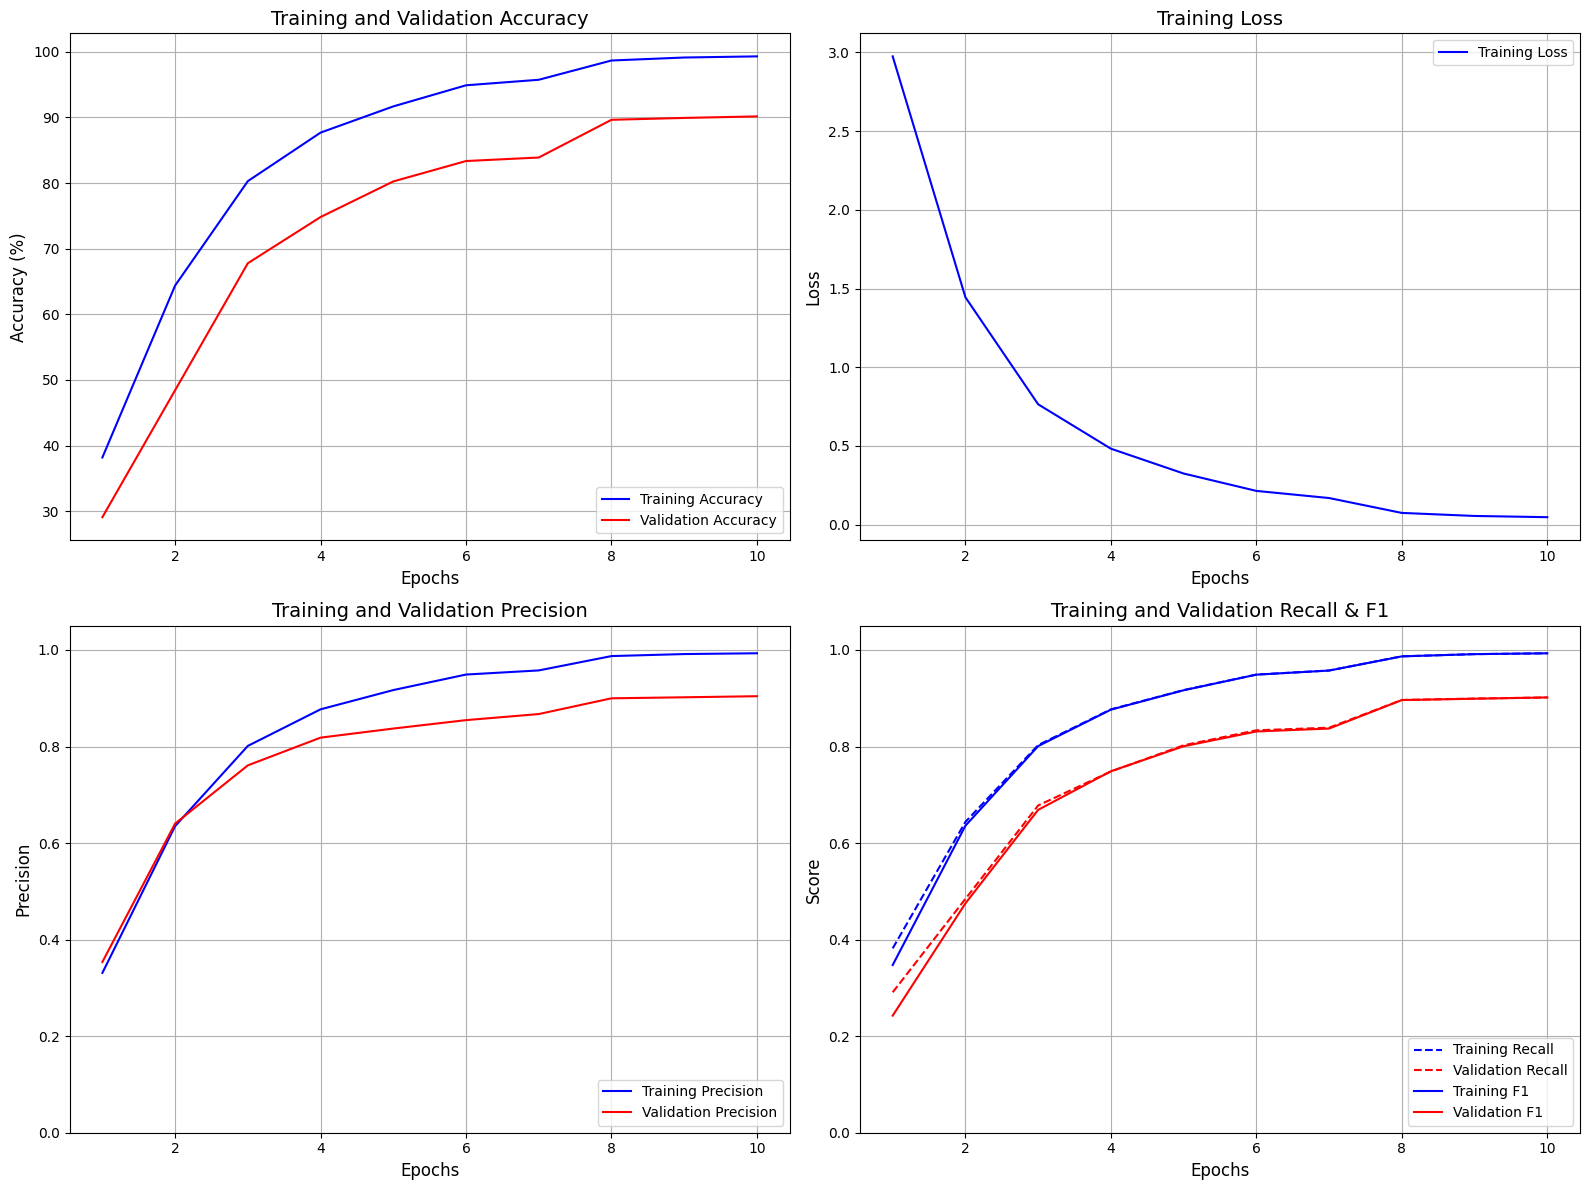

Final Model Performance Metrics:
Training Accuracy        : 99.31%
Validation Accuracy      : 90.16%
Training Precision       : 0.9932
Validation Precision     : 0.9042
Training Recall          : 0.9931
Validation Recall        : 0.9016
Training F1-score        : 0.9931
Validation F1-score      : 0.9016


In [13]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
epochs = range(1, len(training_accs) + 1)

# Plot 1: Accuracy
axs[0, 0].plot(epochs, training_accs, 'b-', label='Training Accuracy')
axs[0, 0].plot(epochs, test_accs, 'r-', label='Validation Accuracy')
axs[0, 0].set_title('Training and Validation Accuracy', fontsize=14)
axs[0, 0].set_xlabel('Epochs', fontsize=12)
axs[0, 0].set_ylabel('Accuracy (%)', fontsize=12)
axs[0, 0].grid(True)
axs[0, 0].legend(loc='lower right')

# Plot 2: Loss
axs[0, 1].plot(epochs, training_losses, 'b-', label='Training Loss')
axs[0, 1].set_title('Training Loss', fontsize=14)
axs[0, 1].set_xlabel('Epochs', fontsize=12)
axs[0, 1].set_ylabel('Loss', fontsize=12)
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper right')

# Plot 3: Precision
axs[1, 0].plot(epochs, training_precisions, 'b-', label='Training Precision')
axs[1, 0].plot(epochs, test_precisions, 'r-', label='Validation Precision')
axs[1, 0].set_title('Training and Validation Precision', fontsize=14)
axs[1, 0].set_xlabel('Epochs', fontsize=12)
axs[1, 0].set_ylabel('Precision', fontsize=12)
axs[1, 0].grid(True)
axs[1, 0].set_ylim([0, 1.05])
axs[1, 0].legend(loc='lower right')

# Plot 4: Recall and F1
axs[1, 1].plot(epochs, training_recalls, 'b--', label='Training Recall')
axs[1, 1].plot(epochs, test_recalls, 'r--', label='Validation Recall')
axs[1, 1].plot(epochs, training_f1s, 'b-', label='Training F1')
axs[1, 1].plot(epochs, test_f1s, 'r-', label='Validation F1')
axs[1, 1].set_title('Training and Validation Recall & F1', fontsize=14)
axs[1, 1].set_xlabel('Epochs', fontsize=12)
axs[1, 1].set_ylabel('Score', fontsize=12)
axs[1, 1].grid(True)
axs[1, 1].set_ylim([0, 1.05])
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Display final metrics
final_metrics = {
    "Training Accuracy": f"{training_accs[-1]:.2f}%",
    "Validation Accuracy": f"{test_accs[-1]:.2f}%",
    "Training Precision": f"{training_precisions[-1]:.4f}",
    "Validation Precision": f"{test_precisions[-1]:.4f}",
    "Training Recall": f"{training_recalls[-1]:.4f}",
    "Validation Recall": f"{test_recalls[-1]:.4f}",
    "Training F1-score": f"{training_f1s[-1]:.4f}",
    "Validation F1-score": f"{test_f1s[-1]:.4f}"
}

# Print final metrics table
print("Final Model Performance Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric:25s}: {value}")

<p style="text-align:left;">
    <font face="Georgia" size=7 color="green">Testing some samples</font>
</p>

In [14]:
model = torch.load('/kaggle/working/best_model.pth')

/tmp/ipykernel_31/2120149441.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/working/best_model.pth')


In [18]:
def pred_car(model, dataset= 1, image_path = 'Audi S5 Coupe 2012/03647.jpg'):
    if dataset == 1:
        root_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
    elif dataset == 2:
        root_dir = '/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/test'
    else:
        raise ValueError('Valid choices are 1 or 2')

    image_path = os.path.join(root_dir, image_path)
    model.eval()
    
    # transforms for the input image
    loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    image_path = image_path
    image = Image.open(image_path)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0).cuda()
    output = model(image)
    
    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    conf, predicted = torch.max(probabilities, 1)
    display(Image.open(image_path))
    print(f"Predicted class: {all_classes[predicted.item()]} with confidence: {conf.item():.4f}")



In [26]:
pred_car(model_ft, 2, 'Peugeot-405/Peugeot-405 (467).jpg')

Predicted class: Peugeot-405 with confidence: 0.9999


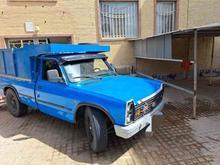

Predicted class: Nissan-Zamiad with confidence: 0.9990


In [21]:
pred_car(model_ft, 2, 'Nissan-Zamiad/Nissan-Zamiad (361).jpg')

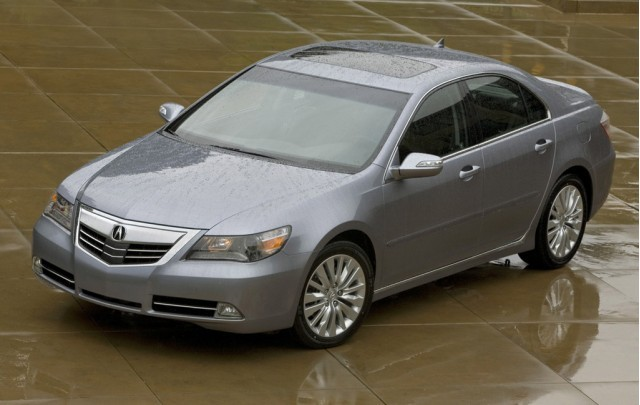

Predicted class: Acura RL Sedan 2012 with confidence: 0.9964


In [22]:
pred_car(model_ft, 1, 'Acura RL Sedan 2012/05260.jpg')

In [23]:
pred_car(model_ft, 1, 'Bentley Continental GT Coupe 2007/03813.jpg')

Predicted class: Bentley Continental GT Coupe 2007 with confidence: 0.8820
